In [1]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Plot ROI mean effect

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


thr: 0
t: 2.499476078457607
p: 0.014082141862959831


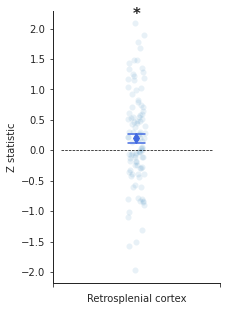

In [69]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game2_fmri>=0.5)and(game2_test_acc>0.8)')
subjects = data['Participant_ID'].to_list()
# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.4.17/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
#roi = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.superiorfrontal.nii.gz')#lh.lateralorbitofrontal.nii.gz
roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-lRSC.nii.gz')
roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-rRSC.nii.gz')
roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
thr_range = [0]
for thr in thr_range:
    roi_thr = image.binarize_img(roi, thr)
    subs_mean_activity = np.mean(masking.apply_mask(sub_cmap_paths, roi_thr), axis=1)

    # mean
    t_statistic, p_value = ttest_1samp(subs_mean_activity, 0)
    print('thr: {}'.format(thr))
    print('t:', t_statistic)
    print('p:', p_value)

    # plot
    fig,ax = plt.subplots(figsize=(3,5))
    xjitter = np.random.uniform(-0.05, 0.05,size=len(subs_mean_activity))
    sns.scatterplot(x=xjitter,y=subs_mean_activity,alpha=0.1)
    # Add a point to represent the mean of subs_mean_activity
    mean_val = subs_mean_activity.mean()
    plt.plot(0, mean_val*1.02, marker='d', markersize=7,color='royalblue',zorder=10)
    sns.barplot(data=subs_mean_activity,facecolor='None',edgecolor='None',capsize=0.1,errcolor='royalblue',errwidth=1.5,errorbar='se', width=0.3)

    # Add a horizontal line
    ax.hlines(y=0, xmin=-0.45, xmax=0.45, colors='black', linestyles='--',linewidth=0.7)
    ax.set_ylabel('Z statistic')
    ax.set_xlabel('Retrosplenial cortex')

    # Remove top and right spines
    sns.despine(top=True, right=True)

    # Modify the bottom and left spines
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    # Set custom ticks for the x-axis and y-axis
    plt.xticks([-0.5, 0.5])
    #plt.yticks(np.arange(0, 0.25, 0.1))
    # Add tick lines to the bottom and left spines
    ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
    ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')

    # Add asterisks on top of each bar
    vmean = np.mean(subs_mean_activity)
    ax.text(0, subs_mean_activity.max()*1.01, '*',ha='center', va='bottom',weight='bold',size=15)
    plt.savefig("/mnt/workdir/DCM/Result/MRI/Game difference/Hexagon/hexagon_sub-hp_roi-RSC.svg", dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

## Plot ROI covairate effect

In [215]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("(game2_fmri>=0.5)")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'

# .gz'
#cmap_template = r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_rsa/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'
# set roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi2, img2=roi1)

#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_mask_MNI152NL.nii.gz')
roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.lateralorbitofrontal.nii.gz')
roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.lateralorbitofrontal.nii.gz')
roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob_R.nii.gz')
#roi = image.binarize_img(roi,10)

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

r 0.1213 p 0.093


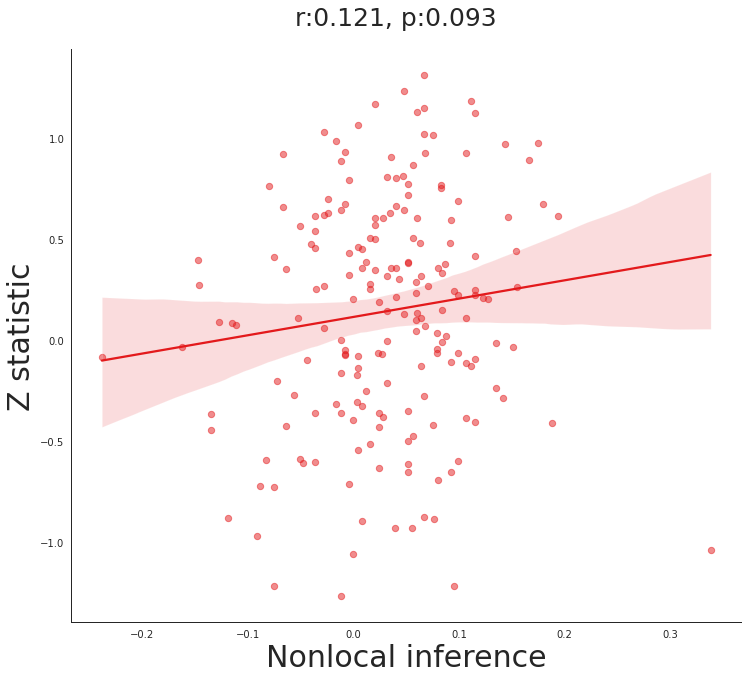

In [216]:
participants_data['beh_diff'] = participants_data['game2_test_acc'] - participants_data['game1_acc']
# get covariate
covary_variable = participants_data['beh_diff'].to_list()
# plot figure
fig, ax = plt.subplots(figsize=(12,10))
color = sns.color_palette("Paired")
plt.scatter(covary_variable, subs_mean_activity,color=color[5], s=40,alpha=0.5)
sns.regplot(x=covary_variable, y=subs_mean_activity,color=color[5],order=1,scatter=False)

ax.set_xlabel('Nonlocal inference', fontsize=30)
ax.set_ylabel('Z statistic', fontsize=30)

# Remove top and right spines
sns.despine(top=True, right=True)
# Modify the bottom and left spines
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set custom ticks for the x-axis and y-axis
#plt.xticks([])
#plt.yticks(np.arange(0, 0.25, 0.1))
# Add tick lines to the bottom and left spines

r, p = pearsonr(covary_variable,subs_mean_activity)
print('r',round(r,4),'p',round(p,4))
#move overall title up
fig.subplots_adjust(top=0.92)
if p < 0.001:
    fig.suptitle('r:{}  p<0.001'.format(round(r,3)),size=25)
else:
    fig.suptitle('r:{}, p:{}'.format(round(r,3),round(p,3)),size=25)

## Plot brain activity with separate age stage

In [159]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
junv_data = participants_data.query('(game1_fmri>=0.5)and(Age<18)')
adult_data = participants_data.query('(game1_fmri>=0.5)and(Age>=18)')
junv_subjects = junv_data['Participant_ID'].to_list()
adult_subjects = adult_data['Participant_ID'].to_list()

# set cmap template
cmap_template = r'/mnt/data/DCM/result_backup/2023.4.17/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'


# set roi
roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
#roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.entorhinal.nii.gz')
#roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.entorhinal.nii.gz')
#roi = image.math_img('img1+img2',img1=roi1,img2=roi2)
#roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob_L.nii.gz')
#roi = image.binarize_img(roi,10)
#roi  = image.load_img(r'/mnt/workdir/DCM/docs/Reference/ACC/ACC_MNI152NL.nii.gz')
#roi = image.load_img(r'/mnt/workdir/DCM/result/ROI/anat/juelich_EC_MNI152NL_prob_L.nii.gz')
#roi = image.binarize_img(roi,10)

# get activity in ROI
junv_subs_cmap_list = [cmap_template.format(sub_id) for sub_id in junv_subjects]
junv_subs_mean_activity = np.mean(masking.apply_mask(junv_subs_cmap_list, roi),axis=1)

adult_subs_cmap_list = [cmap_template.format(sub_id) for sub_id in adult_subjects]
adult_subs_mean_activity = np.mean(masking.apply_mask(adult_subs_cmap_list, roi),axis=1)
# get covariate
junv_covary_variable = junv_data['Age'].to_list()
adult_covary_variable = adult_data['Age'].to_list()

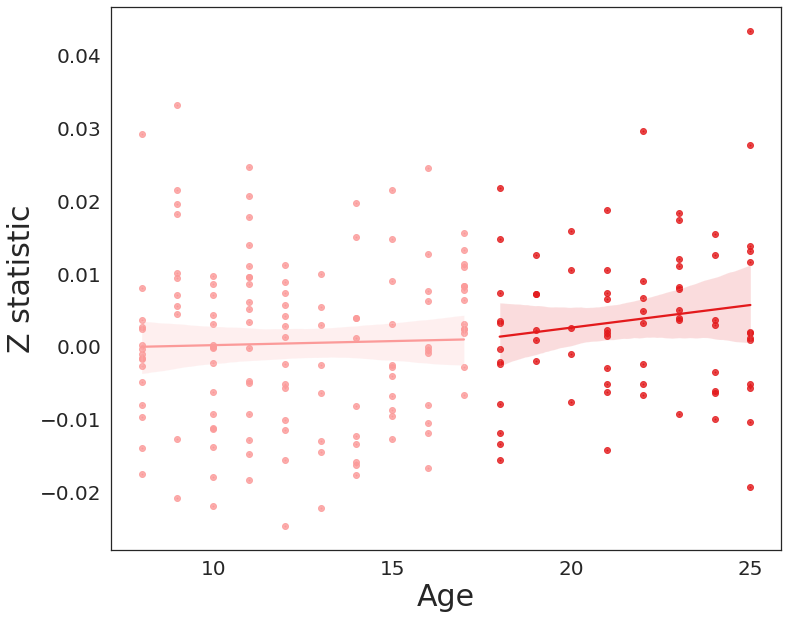

In [160]:
fig, ax = plt.subplots(figsize=(12,10))
color = sns.color_palette("Paired")
plt.scatter(junv_covary_variable, junv_subs_mean_activity,color=color[4],label='junvenal', s=1.)
plt.scatter(adult_covary_variable, adult_subs_mean_activity,color=color[5],label='adult', s=1.)
sns.regplot(x=junv_covary_variable, y=junv_subs_mean_activity,color=color[4])
sns.regplot(x=adult_covary_variable, y=adult_subs_mean_activity,color=color[5])
ax.set_xlabel('Age', fontsize=30)
ax.set_ylabel('Z statistic', fontsize=30)
#ax.set_yticks([-1, 0, 1])
ax.set_xticks([10, 15, 20, 25])
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig(r"/mnt/workdir/DCM/result/game2/distance_age_effect_mPFC.svg",dpi=300,bbox_inches='tight',pad_inches=0)

In [207]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("game2_fmri>=0.5")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_rsa/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'

# set roi
roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.lateralorbitofrontal.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.lateralorbitofrontal.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#roi = image.binarize_img(roi,10)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.superiorfrontal.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.superiorfrontal.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)
participants_data['ROI_activity'] = subs_mean_activity
participants_data['beh_diff'] = participants_data['game2_test_acc'] - participants_data['game1_acc']

The group difference bettwen children and adolescents t = -1.331, p = 0.186
The group difference bettwen adolescents and adults t = 0.680, p = 0.498
The group difference bettwen children and adults t = -0.828, p = 0.409


Text(1, 0.32422890607046534, 'n.s.')

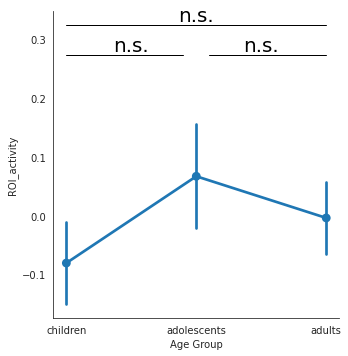

In [206]:
# Add age group categories
age_bins = [7, 12, 17, 25]
age_labels = ['children', 'adolescents', 'adults']
participants_data['Age_group'] = pd.cut(participants_data['Age'], bins=age_bins, labels=age_labels)
g = sns.catplot(x='Age_group', y='ROI_activity', data=participants_data, kind='point', errorbar="se",color='salomn')
g.set_axis_labels("Age Group", "ROI_activity")
g.fig.set_size_inches(5, 5)

# get the acivities of each age group
children_data = participants_data.query("Age_group=='children'")
adolescents_data = participants_data.query("Age_group=='adolescents'")
adult_data = participants_data.query("Age_group=='adults'")
# compare activity size between each pair of the three age groups using t-tests
def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign

height = participants_data['ROI_activity'].mean() + 0.5*participants_data['ROI_activity'].std()
# compare children and adolescents
t,p = ttest_ind(children_data['ROI_activity'], adolescents_data['ROI_activity'])
print('The group difference bettwen children and adolescents t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 0.9], [height, height], 'k-', lw=1)
g.ax.text(0.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare children and adults
t,p =  ttest_ind(adolescents_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen adolescents and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([1.1, 2], [height, height], 'k-', lw=1)
g.ax.text(1.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare adolescents and adults
t,p = ttest_ind(children_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen children and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 2], [height+0.05, height+0.05], 'k-', lw=1)
g.ax.text(1, height+0.05, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

In [156]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

r1,p1 = pearsonr(junv_covary_variable, junv_subs_mean_activity)
r2,p2 = pearsonr(adult_covary_variable, adult_subs_mean_activity)

# Sample sizes for each correlation coefficient
n1 = len(junv_covary_variable)
n2 = len(adult_covary_variable)
print(r1,p1)
print(r2,p2)

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

print(independent_corr(r1 , r2, n1, n2, method='fisher',twotailed=False))

0.15824247935329444 0.0721510885192667
0.04645538278835484 0.6963331207166016
(0.7597311319521073, 0.22370765788758806)


/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


                            OLS Regression Results                            
Dep. Variable:          Inference_acc   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     53.43
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           2.56e-19
Time:                        17:55:40   Log-Likelihood:                 180.68
No. Observations:                 203   AIC:                            -355.4
Df Residuals:                     200   BIC:                            -345.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5380      0

<ipython-input-69-54e539010b02>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hexagon_modulation'] = subs_mean_activity
<ipython-input-69-54e539010b02>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Inference_acc'] = data['game1_acc']
<ipython-input-69-54e539010b02>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


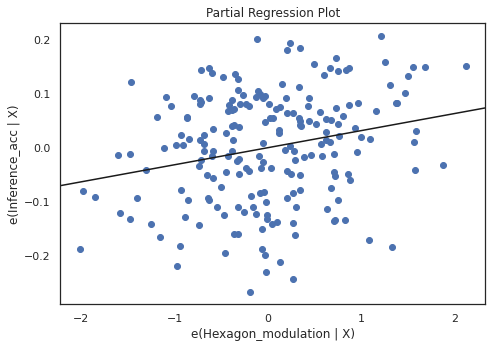

In [69]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("game1_fmri>=0.5")
subjects_id = data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/cv_test_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_even_zmap.nii.gz'

# set roi
roi = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
#roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/cv_train_hexagon_spct/EC_thr3.1.nii.gz')
for thr in [0.1]:
    roi_thr_bin = image.binarize_img(roi, thr)
    # extract mean activity
    subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
    subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi_thr_bin),axis=1)

    data['Hexagon_modulation'] = subs_mean_activity
    data['Inference_acc'] = data['game1_acc']

    # Plot the partial correlation plot with age held constant
    import statsmodels.api as sm
    fig = sm.graphics.plot_partregress("Inference_acc", "Hexagon_modulation",["Age"],data=data,obs_labels=False)
    fig.set_size_inches(7,5)
    sns.set_theme(style="white")
    fig.tight_layout()
    fig.show()

    X = data[['Hexagon_modulation','Age']]
    Y = data['Inference_acc']

    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)
    model_summary = model.summary()
    print(model_summary)

# A GLM include age, brain actvitiy and inference

In [208]:
# using the brian acitvitiy of multiple ROIs and age to predict inference accuracy

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("game2_fmri>=0.5")
subjects_id = data['Participant_ID'].to_list()

# load ROI
# load HC
# rHC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# lHC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# hc = image.math_img('np.logical_or(img1,img2)', img1=rHC, img2=lHC)
# load EC
# ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob_R.nii.gz')
# ec = image.binarize_img(ec,10)
# load OFC
rpOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.lateralorbitofrontal.nii.gz')
lpOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.lateralorbitofrontal.nii.gz')
ofc = image.math_img('np.logical_or(img1,img2)', img1=rpOFC, img2=lpOFC)
# load vmPFC
vmPFC  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')

# put ROIs into a dict
rois = {'OFC':ofc,'vmPFC':vmPFC}

# load the brain activity of each ROI
# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'
#cmap_template = r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_rsa/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'

# get each subject's activity in each ROI
for troi_name,troi in rois.items():
    print(troi_name,'is processing')
    # get activity in ROI
    subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
    subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, troi),axis=1)
    data[troi_name] = subs_mean_activity

OFC is processing


<ipython-input-208-e5f8571b6169>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[troi_name] = subs_mean_activity


vmPFC is processing


In [210]:
# using GLM to predict inference accuracy from brain activity and age
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
import statsmodels.api as sm
X = data[['vmPFC','Age']]
Y = data['beh_diff']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               beh_diff   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     7.143
Date:                Fri, 28 Apr 2023   Prob (F-statistic):            0.00102
Time:                        22:14:07   Log-Likelihood:                 231.83
No. Observations:                 193   AIC:                            -457.7
Df Residuals:                     190   BIC:                            -447.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0184      0.017     -1.102      0.2

<ipython-input-210-9d78bb101899>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']


In [27]:
from statsmodels.stats.mediation import Mediation

# Define the outcome, predictor, and mediator variables
outcome = 'game1_acc'
predictor = 'Age'
mediator = 'EC'

# Fit the mediator model (M ~ X)
mediator_model = sm.OLS.from_formula(f'{mediator} ~ {predictor}', data=data)

# Fit the outcome model (Y ~ X + M)
outcome_model = sm.OLS.from_formula(f'{outcome} ~ {predictor} + {mediator}', data=data)

# Perform mediation analysis using the Mediation class
mediation_analysis = Mediation(outcome_model, mediator_model, exposure=predictor, mediator=mediator)

# Estimate the average causal mediation effect (ACME) using bootstrapping for confidence intervals
mediation_result = mediation_analysis.fit(n_rep=5000)  # You can increase n_rep for better accuracy

# Print the results
print(mediation_result.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.000444       -0.005245        0.006275   0.8756
ACME (treated)            0.000444       -0.005245        0.006275   0.8756
ADE (control)             0.012448        0.009834        0.015050   0.0000
ADE (treated)             0.012448        0.009834        0.015050   0.0000
Total effect              0.012892        0.006543        0.019181   0.0012
Prop. mediated (control)  0.032110       -0.740458        0.339916   0.8744
Prop. mediated (treated)  0.032110       -0.740458        0.339916   0.8744
ACME (average)            0.000444       -0.005245        0.006275   0.8756
ADE (average)             0.012448        0.009834        0.015050   0.0000
Prop. mediated (average)  0.032110       -0.740458        0.339916   0.8744


In [178]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats  import ttest_1samp
import statsmodels.formula.api as smf

def bootstrap_indirect_effect(data, iv, m, dv, n_bootstraps=5000, ci=0.95):
    indirect_effects = []
    for _ in range(n_bootstraps):
        bootstrap_data = data.sample(frac=1, replace=True)

        path_a = smf.ols(f"{m} ~ {iv}", data=bootstrap_data).fit()
        path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=bootstrap_data).fit()

        indirect_effect = path_a.params[1] * path_b.params[1]
        indirect_effects.append(indirect_effect)

    lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
    upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

    return lower, upper,indirect_effects


# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = 'vmPFC'
dv = 'beh_diff'

# Path a: IV -> M
path_a = smf.ols(f"{m} ~ {iv}", data=data).fit()

# Path b: M -> DV, controlling for IV
path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=data).fit()
lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.4f}, {upper:.4f})")

Bootstrapped 95% confidence interval for the indirect effect: (-0.0001, 0.0013)


(array([  12.,   61.,  510., 2133., 3495., 2530.,  948.,  258.,   47.,
           6.]),
 array([-9.12817824e-04, -5.98065080e-04, -2.83312336e-04,  3.14404080e-05,
         3.46193152e-04,  6.60945896e-04,  9.75698640e-04,  1.29045138e-03,
         1.60520413e-03,  1.91995687e-03,  2.23470962e-03]),
 <BarContainer object of 10 artists>)

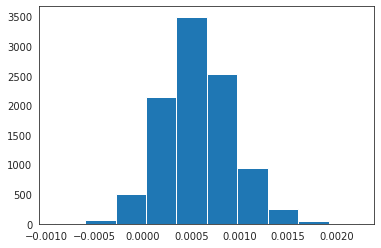

In [179]:
import matplotlib.pyplot as plt
plt.hist(indirect_effects)